In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import csv
import pandas as pd

data = pd.read_csv('data/GlobalLandTemperaturesByCity.csv',sep=',',index_col=False)

poland_data = data[data['Country'] == 'Poland']

poland_data.to_csv('poland_data.csv',index=False)

In [4]:
# Listing unique cities in poland_data

list_city = list(pd.unique(poland_data['City']))
list_city

['Bialystok',
 'Bielsko Biala',
 'Bydgoszcz',
 'Bytom',
 'Chorzow',
 'Cracow',
 'Czestochowa',
 'Dabrowa Gornicza',
 'Elblag',
 'Gdansk',
 'Gdynia',
 'Gliwice',
 'Gorzow Wielkopolski',
 'Kalisz',
 'Katowice',
 'Kielce',
 'Koszalin',
 'Legnica',
 'Lublin',
 'Olsztyn',
 'Opole',
 'Plock',
 'Poznan',
 'Radom',
 'Ruda Slaska',
 'Rybnik',
 'Rzeszow',
 'Sosnowiec',
 'Szczecin',
 'Tarnow',
 'Torun',
 'Tychy',
 'Walbrzych',
 'Warsaw',
 'Wloclawek',
 'Wroclaw',
 'Zabrze',
 'Zielona Gora']

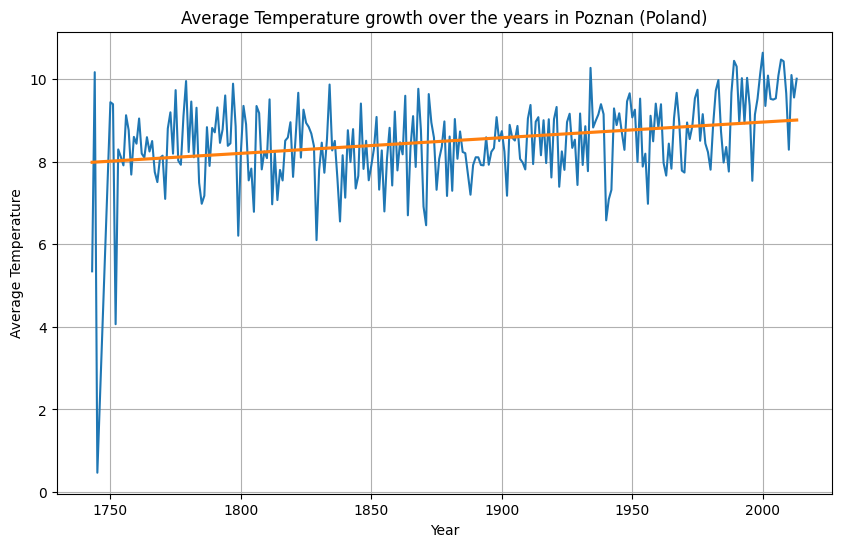

In [21]:
# I choose Poznan as the main city, now i want to create a visualization that will show the growth of temperature over the years
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

poland_data = pd.read_csv('poland_data.csv',index_col=False)

# creating Poznan dataset
df_poznan = poland_data.loc[poland_data['City'] == 'Poznan'].copy()

# extracting year form date
df_poznan.loc[:, 'dt'] = pd.to_datetime(df_poznan['dt'])
df_poznan.loc[:, 'Year'] = df_poznan['dt'].dt.year

# dropping NA values
df_poznan.dropna(subset=['AverageTemperature'],inplace=True)

plt.figure(figsize=(10,6))
ax = sns.lineplot(x='Year',y='AverageTemperature',data=df_poznan,errorbar=None)
sns.regplot(x='Year', y='AverageTemperature',data=df_poznan,ci=None,scatter=False,ax=ax)

plt.title("Average Temperature growth over the years in Poznan (Poland)")
plt.xlabel("Year")
plt.ylabel("Average Temperature")
plt.grid(True)
plt.show()




          dt  AverageTemperature  AverageTemperatureUncertainty       City  \
0 1743-11-01               2.347                          1.799  Bialystok   
5 1744-04-01               7.411                          3.192  Bialystok   
6 1744-05-01              11.046                          1.533  Bialystok   
7 1744-06-01              14.492                          1.329  Bialystok   
8 1744-07-01              16.841                          1.284  Bialystok   

  Country Latitude Longitude  Year  
0  Poland   53.84N    23.18E  1743  
5  Poland   53.84N    23.18E  1744  
6  Poland   53.84N    23.18E  1744  
7  Poland   53.84N    23.18E  1744  
8  Poland   53.84N    23.18E  1744  


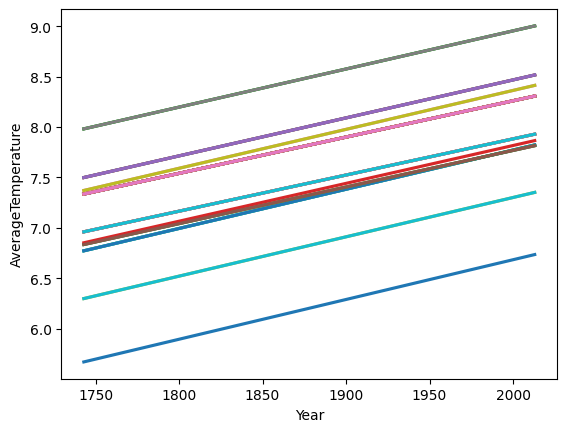

In [30]:
# now I want to create a new dataframe that contains countries column and column with value that is calculated by subtracing highest value on regression line by lowest value

# Cleaning dataset to prevent future problems with NA values
df_cleaned = poland_data.copy()

df_cleaned = df_cleaned.dropna(subset=['AverageTemperature'])

# Using .loc to change the data type of 'dt' column to datetime
df_cleaned['dt'] = pd.to_datetime(df_cleaned['dt'])

# Using .loc to create a new column 'Year' and assign the year values from 'dt' column
df_cleaned.loc[:, 'Year'] = df_cleaned['dt'].dt.year

# Creating an empty DataFrame 'result_df' with columns 'City' and 'Subtraction'
result_df = pd.DataFrame(columns=['City', 'Subtraction'])
grouped = df_cleaned.groupby('City')

print(df_cleaned.head())

# Calculate the subtraction for each city
for city, group in grouped:
    if len(group['Year']) >= 2:
        # Fit the linear regression model
        reg_model = sns.regplot(x='Year', y='AverageTemperature', data=group, ci=None, scatter=False,
                                label=city)

        slope, intercept = reg_model.get_lines()[0].get_data()

        # Calculate the highest and lowest regression line points
        highest_point = slope.max() * group['Year'].max() + intercept.max()
        lowest_point = slope.min() * group['Year'].min() + intercept.min()

        # Calculate the subtraction and store the result in the new DataFrame
        subtraction = highest_point - lowest_point
        result_df = pd.concat([result_df, pd.DataFrame({'City': [city], 'Subtraction': [subtraction]})], ignore_index=True)



# Convert the 'Subtraction' column to numeric data type
result_df['Subtraction'] = pd.to_numeric(result_df['Subtraction'], errors='coerce')
#result_df = result_df.dropna(subset=['Subtraction'], inplace=True)


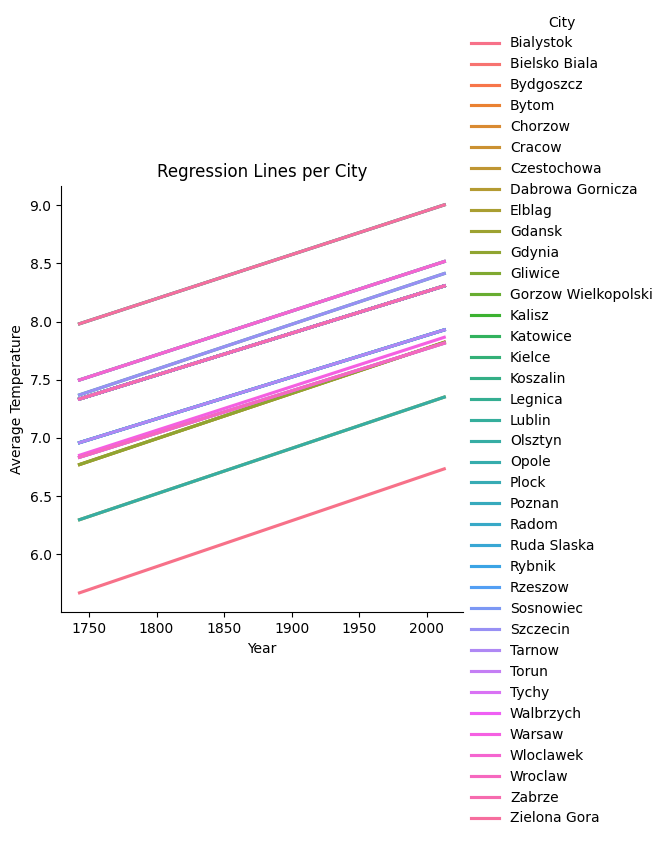

In [36]:
sns.lmplot(data=df_cleaned,x='Year',y='AverageTemperature',hue='City',ci=None,scatter=None)


plt.xlabel('Year')
plt.ylabel('Average Temperature')
plt.title('Regression Lines per City')

plt.show()

The plot above doesn't show us much information. Many lines are hidden undeneath of other lines. This information can make me think that many cities has the same degree of Average Temperature growth.

Also it all depends on how the whole data was gathered. Or if some temperatures were rounded up for specific area. For example there are some cities that are in the same voivodeship in Poland, so its possible that there weren't many changes for temperature, therefore the same Average Temperature growth. Poland is a very unique country. From the top, there is a sea, Baltic Sea. Now going south, land is getting higher and higher to the southest area of Poland that ends up at the mountains. Such diversity of landscape surely influence the Average Temperature that was calculated for cities that lies near sea or mountains.

It is possible that for the other country, that also is in Europe, plots would look different (not drastically but still), meaning there are other variables that influence Average Temperature data.


Now I want to take 3 cities with highest regression line (I'am talking about slope values). 

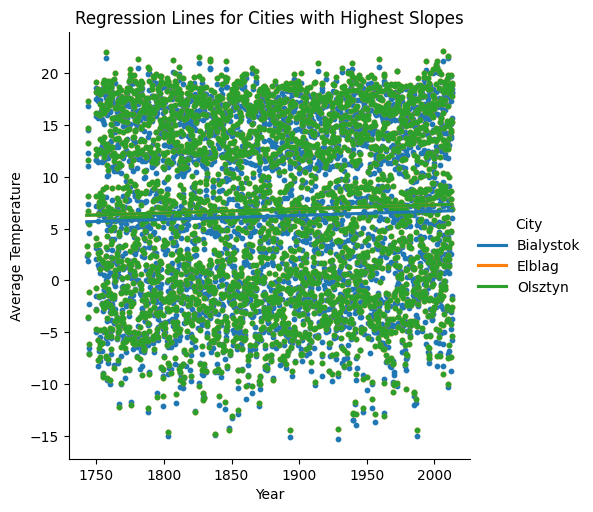

In [57]:
import numpy as np

city_slopes = {}

for city, data in df_cleaned.groupby('City'):
    x = data['Year']
    y = data['AverageTemperature']
    slope, _ = np.polyfit(x,y,1)
    city_slopes[city] = slope

highest_slopes_cities = sorted(city_slopes,key=city_slopes.get,reverse=True)[:3]

df_highest = df_cleaned[df_cleaned['City'].isin(highest_slopes_cities)]

sns.lmplot(data=df_highest,x='Year',y='AverageTemperature',hue='City',ci=None,scatter=None)

plt.xlabel('Year')
plt.ylabel('Average Temperature')
plt.title('Regression Lines for Cities with Highest Slopes')

# Add data points on top of the lines
for city, data in df_highest.groupby('City'):
    plt.scatter(data['Year'], data['AverageTemperature'], label=city, s=10)


plt.show()


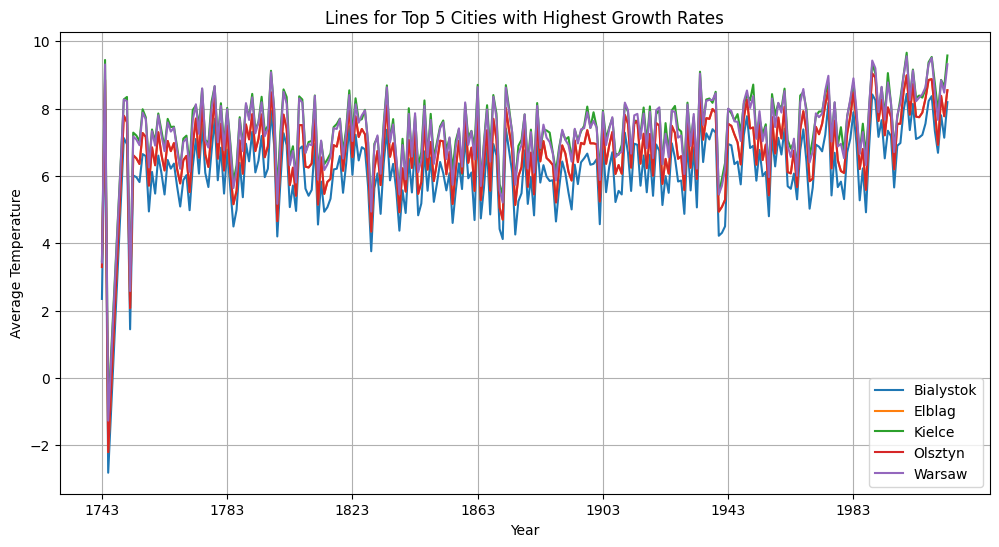

In [54]:
# Calculate the regression slope for each city and the growth rate of each slope
city_slopes = {}
for city, data in df_cleaned.groupby('City'):
    x = data['Year']
    y = data['AverageTemperature']
    slope, _ = np.polyfit(x, y, 1)
    growth_rate = (slope - y.iloc[0]) / (x.iloc[-1] - x.iloc[0])
    city_slopes[city] = growth_rate

# Sort cities by their growth rate values and select the top 5 cities
top_5_growth_cities = sorted(city_slopes, key=city_slopes.get, reverse=True)[:5]

# Filter the 'df_cleaned' DataFrame to include only the top 5 cities with highest growth rates
df_top_5_growth_cities = df_cleaned[df_cleaned['City'].isin(top_5_growth_cities)]

# Create the plot with regression lines for the top 5 cities with highest growth rates
plt.figure(figsize=(12, 6))  # Set the figure width to 12 inches
for city, data in df_top_5_growth_cities.groupby('City'):
    sns.lineplot(data=data, x='Year', y='AverageTemperature', label=city,errorbar=None)

    # Add year legend to the last value of each regression line
    last_year = data['Year'].iloc[-1]
    last_temp = data['AverageTemperature'].iloc[-1]
    plt.annotate(last_year, xy=(last_year, last_temp), xytext=(5, -5), textcoords='offset points')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Average Temperature')
plt.title('Lines for Top 5 Cities with Highest Growth Rates')

# Set x-axis ticker interval to show every 40 years
plt.xticks(np.arange(df_cleaned['Year'].min(), df_cleaned['Year'].max() + 1, 40))

# Show the plot
plt.legend()
plt.grid(True)  # Add grid lines to the plot
plt.show()